<a href="https://colab.research.google.com/github/crodier1/data_science/blob/main/Pytorch_NLP_Sentiment_Analysis_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/exercises/AirlineSentimentTweets.csv

File ‘AirlineSentimentTweets.csv’ already there; not retrieving.



In [ ]:
df = pd.read_csv('AirlineSentimentTweets.csv')



In [ ]:
K = len(set(df['airline_sentiment']))
K


3

In [ ]:
df['airline_sentiment'] = df['airline_sentiment'].map({'negative':0, 'neutral':1, 'positive':2})

In [ ]:
df2 = df[['text', 'airline_sentiment_confidence','airline_sentiment']]


In [ ]:
df_train, df_test = train_test_split(df2, test_size=0.33)

In [ ]:
idx = 1
word2idx = {'<PAD>': 0}

In [ ]:
for i,row in df_train.iterrows():
  for word in row['text'].lower().split(' '):
    if word not in word2idx:
      word2idx[word] = len(word2idx)

In [ ]:
def encode_sentence(doc):
  sentences = []

  for i,row in doc.iterrows():
    sentence = [float(word2idx[word]) for word in row['text'].lower().split(' ') if word.lower() in word2idx]
    sentence.append(row['airline_sentiment_confidence'])
    sentences.append(sentence)


  return sentences

In [ ]:
train_sentences = encode_sentence(df_train)
test_sentences = encode_sentence(df_test)

In [ ]:
def data_generator(X,y, batch_size=32):
  X,y = shuffle(X,y)

  b_batches = int(np.ceil(len(X)/ batch_size))

  for i in range(b_batches):
    end = min((i+1)*batch_size, len(X))
    X_batch = X[i*batch_size:end]
    y_batch = y[i*batch_size:end]

    max_len = np.max([len(x) for x in X_batch])

    for j in range(len(X_batch)):
      x = X_batch[j]

      pad = [0] * (max_len - len(x))
      X_batch[j] = pad + x

    X_batch = torch.from_numpy(np.array(X_batch)).long()
    y_batch = torch.from_numpy(np.array(y_batch)).long()

    yield X_batch, y_batch

In [ ]:
device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
train_gen = lambda: data_generator(train_sentences, df_train.airline_sentiment)
test_gen = lambda: data_generator(test_sentences, df_test.airline_sentiment)

In [ ]:
class CNN(nn.Module):
  def __init__(self, n_vocab, embed_size, n_outputs):
    super(CNN, self).__init__()
    self.V = n_vocab
    self.D = embed_size
    self.K = n_outputs

    self.embed = nn.Embedding(self.V, self.D)

    self.conv1 = nn.Conv1d(self.D, 32, 3,padding=1)
    self.pool1 = nn.MaxPool1d(2)

    self.conv2 = nn.Conv1d(32, 64, 3,padding=1)
    self.pool2 = nn.MaxPool1d(2)

    self.conv3 = nn.Conv1d(64, 128, 3,padding=1)

    self.dropout = nn.Dropout(0.2)

    self.fc = nn.Linear(128, self.K)

  def forward(self, x):
    out = self.embed(x)

    out = out.permute(0,2,1)

    out = self.conv1(out)
    out = F.relu(out)
    out = self.pool1(out)

    out = self.conv2(out)
    out = F.relu(out)
    out = self.pool2(out)

    out = self.conv3(out)
    out = F.relu(out)

    out = out.permute(0,2,1)

    out, _ = torch.max(out, 1)

    out = self.fc(out)

    return out

In [ ]:
model = CNN(len(word2idx), 20, K)
model.to(device)

CNN(
  (embed): Embedding(20770, 20)
  (conv1): Conv1d(20, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def batch_gd(model, criterion, optimizer, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []

    for inputs, targets in train_gen():

      inputs, targets = inputs.to(device), targets.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)

      loss = criterion(outputs, targets)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    test_loss = []

    for inputs, targets in test_gen():

      inputs, targets = inputs.to(device), targets.to(device)

      outputs = model(inputs)

      loss = criterion(outputs, targets)

      test_loss.append(loss.item())

    test_losses[it] = np.mean(test_loss)
    train_losses[it] = np.mean(train_loss)

    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_losses[it]:.4f}, Test Loss: {test_losses[it]:.4f}, Duration: {dt}')

  return train_losses, test_losses

In [ ]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, 10)

Epoch 1/10, Train Loss: 0.8356, Test Loss: 0.7840, Duration: 0:00:04.842005
Epoch 2/10, Train Loss: 0.7469, Test Loss: 0.6988, Duration: 0:00:03.779803
Epoch 3/10, Train Loss: 0.6569, Test Loss: 0.6584, Duration: 0:00:04.029376
Epoch 4/10, Train Loss: 0.5817, Test Loss: 0.6423, Duration: 0:00:04.633372
Epoch 5/10, Train Loss: 0.5164, Test Loss: 0.6452, Duration: 0:00:03.813401
Epoch 6/10, Train Loss: 0.4599, Test Loss: 0.6330, Duration: 0:00:03.734472
Epoch 7/10, Train Loss: 0.4070, Test Loss: 0.6604, Duration: 0:00:05.153693
Epoch 8/10, Train Loss: 0.3564, Test Loss: 0.6849, Duration: 0:00:03.901289
Epoch 9/10, Train Loss: 0.3071, Test Loss: 0.7197, Duration: 0:00:03.749168
Epoch 10/10, Train Loss: 0.2698, Test Loss: 0.7588, Duration: 0:00:04.712462


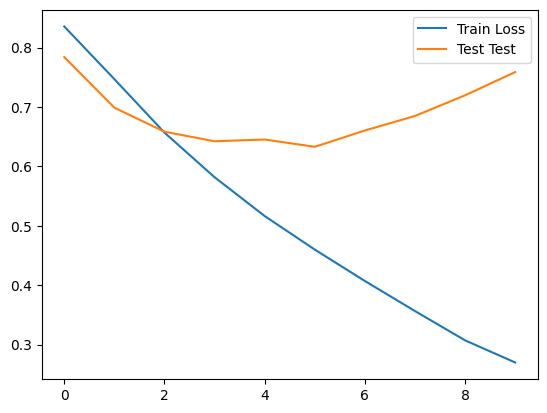

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Test')
plt.legend()
plt.show()

In [ ]:
                                                                                                                                                                                                                                n_correct = 0
n_total = 0

for inputs, targets in train_gen():
  targets = targets.view(-1, 1).float()
  inputs, targets = inputs.to(device), targets.to(device)

  outputs = model(inputs)

  predictions = np.argmax(outputs.detach().numpy(), axis=1)
  n_correct += (predictions == list(targets.flatten())).sum().item()
  n_total += targets.shape[0]


train_acc = n_correct / n_total
print(f'Train Accuracy: {train_acc:.4f}')

test_n_correct = 0
test_n_total = 0

all_predictions = []

for inputs, targets in test_gen():
  targets = targets.view(-1, 1).float()
  inputs, targets = inputs.to(device), targets.to(device)

  outputs = model(inputs)

  predictions = np.argmax(outputs.detach().numpy(), axis=1)
  all_predictions += list(predictions)
  test_n_correct += (predictions == list(targets.flatten())).sum().item()
  test_n_total += targets.shape[0]

test_acc = test_n_correct / test_n_total
print(f'Test Accuracy: {test_acc:.4f}')

Train Accuracy: 0.9234
Test Accuracy: 0.7473
